<a href="https://colab.research.google.com/github/emiliodallatorre/reply-codechallenge-2021/blob/main/explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reply Code Challenge 2021 - "Build the Sky Highway"

This is a solution to the Reply Code Challenge 2021, which is a competition to build an algorithm to place 5G antennas on a map of a city. The goal is to maximize the results following what explained in the [challenge definition file](https://github.com/emiliodallatorre/reply-codechallenge-2021/blob/main/code-challenge-2021.pdf).

The solution is based on a genetic algorithm, which is a metaheuristic inspired by the process of natural selection that belongs to the larger class of evolutionary algorithms. Genetic algorithms are commonly used to generate high-quality solutions to optimization and search problems by relying on bio-inspired operators such as mutation, crossover and selection.

Let's start by importing the libraries we will need.

In [ ]:
from random import random, randint

from matplotlib import pyplot as plt
from tqdm import tqdm

## Reading the input file

The input file contains a complete source set of information about the buildings positions and the information about antennas.

In [ ]:
input_file: str = "data/data_scenarios_b_mumbai.in"

grid_size: tuple

buildings_count: int
antennas_count: int
reward: int

buildings_positions: list = []
buildings_latency_score: list = []
buildings_speed_score: list = []

antennas_positions: list = []
antennas_ids: list = []
antennas_speeds: list = []
antennas_range: list = []

with open(input_file, "r") as f:
    grid_size = tuple(map(int, f.readline().split(" ")))
    buildings_count, antennas_count, reward = tuple(map(int, f.readline().split(" ")))

    for i in range(buildings_count):
        x, y, l, c = tuple(map(int, f.readline().split(" ")))
        buildings_positions.append((x, y))
        buildings_latency_score.append(l)
        buildings_speed_score.append(c)

    for i in range(antennas_count):
        r, s = tuple(map(int, f.readline().split(" ")))
        antennas_speeds.append(s)
        antennas_range.append(r)

As we have read all the information, it now comes to processing them to place the antennas in the best possible way. As we want to approach the problem with a genetic algorithm, we first start by removing the cells that will not be meaningful for the resolution.

To start, we remove all the cells in which, if we'd place an antenna, it would not be able to reach any building. We start with a constructive approach, accepting all the cells that are at a distance from a building less than the maximum range of the antennas.

In [ ]:
def get_distance(a: tuple, b: tuple) -> int:
    return abs(a[0] - b[0]) + abs(a[1] - b[1])


max_antenna_range: int = max(antennas_range)
meaningful_positions: set = set()
for building_position in tqdm(buildings_positions, desc="Selecting meaningful positions"):
    for x in range(building_position[0] - max_antenna_range, building_position[0] + max_antenna_range):
        max_y: int = abs(building_position[0] + max_antenna_range - x)

        for y in range(-max_y + building_position[1], max_y + building_position[1] + 1):
            if get_distance(building_position, (x, y)) <= max_antenna_range:
                meaningful_positions.add((x, y))
meaningful_positions: list = list(meaningful_positions)

Selecting meaningful positions: 100%|██████████| 5/5 [00:00<00:00, 14453.15it/s]


Now, we can start with the genetic algorithm.

## Genetic algorithm

A genetic algorithm is a type of optimization algorithm that mimics the process of natural selection. It is commonly used to solve complex problems by generating a population of possible solutions and then iteratively evolving them towards better solutions.

We start by defining some useful functions that will be used in the algorithm. The first one is the `get_score` function, which takes as input the individual and returns the score of the individual. The score is calculated as the sum of the latency score and the speed score of the buildings that are covered by the antennas.

In [ ]:
def get_score(buildings_positions: list, antennas_positions: list, buildings_speed_score: list,
              buildings_latency_score: list, antennas_range: list, antennas_speeds: list, reward: int) -> int:
    score: int = 0
    are_all_buildings_connected: bool = True

    for building_index, building_position in enumerate(buildings_positions):
        connected_antennas_ids: list = []
        connected_antennas_distances: list = []

        for antenna_index, antenna_position in enumerate(antennas_positions):
            distance: int = get_distance(building_position, antenna_position)
            if distance <= antennas_range[antenna_index]:
                connected_antennas_ids.append(antenna_index)
                connected_antennas_distances.append(distance)

        if len(connected_antennas_ids) > 0:
            max_connection_score: int = 0

            for connected_antennas_index, antenna_id in enumerate(connected_antennas_ids):
                connection_score: int = buildings_speed_score[building_index] * antennas_speeds[
                    antenna_id] - buildings_latency_score[building_index] * connected_antennas_distances[
                                            connected_antennas_index]

                if connection_score > max_connection_score:
                    max_connection_score = connection_score

            score += max_connection_score
        else:
            are_all_buildings_connected = False

    score += reward if are_all_buildings_connected else 0

    return score

This function will permit us to get a score for each individual. This will be used to select the best individuals to breed for the next generation.

We now go to defining the `crossover` function. This function takes as input two individuals and returns two children. The crossover is done by selecting a random point in the individual and swapping the genes after that point. The mutation is done by selecting a random point in the individual and swapping the gene at that point with a random gene from the meaningful positions.

We also define the `mutate` function, which takes as input an individual and returns the individual with a random gene swapped with a random gene from the meaningful positions.

In [ ]:
def crossover(parent_1: list, parent_2: list, meaningful_positions: list, mutation_rate: float) -> list:
    crossover_point: int = randint(0, len(parent_1) - 1)

    child_1: list = parent_1[:crossover_point] + parent_2[crossover_point:]
    child_2: list = parent_2[:crossover_point] + parent_1[crossover_point:]

    if random() < mutation_rate:
        child_1 = mutate(child_1, meaningful_positions)
        child_2 = mutate(child_2, meaningful_positions)

    return [parent_1, parent_2, child_1, child_2]


def mutate(individual: list, meaningful_positions: list) -> list:
    mutation_point: int = randint(0, len(individual) - 1)
    individual[mutation_point] = meaningful_positions[randint(0, len(meaningful_positions) - 1)]

    return individual

We now define the main function of the genetic algorithm, which is the `evolve` function. This function takes as input the initial population, the number of generations to evolve, the mutation rate and the meaningful positions. It returns the best individual found during the evolution.

In [ ]:
def evolve(buildings_positions: list, buildings_speed_score: list,
           buildings_latency_score: list, antennas_range: list, antennas_speeds: list, reward: int,
           meaningful_positions: list, max_loops: int) -> tuple:
    chromosome_length: int = len(antennas_range)
    population: list = []

    mutation_rate = len(meaningful_positions) / 100
    support: list = []
    if len(meaningful_positions) > 100:
        for i in range(100):
            support.append(meaningful_positions.pop(randint(0, len(meaningful_positions) - 1)))

    last_individual: list = []
    for position in support:
        last_individual.append(position)

        if len(last_individual) == chromosome_length:
            population.append(last_individual)
            last_individual = []

    if len(last_individual) > 0:
        for i in range(chromosome_length - len(last_individual)):
            last_individual.append(meaningful_positions[i])

        population.append(last_individual)

    if len(population) % 2 != 0:
        population.append(population[0])

    best_fitnesses_by_generation: list = []
    for i in tqdm(range(max_loops), desc="Genetics"):
        population.sort(key=lambda individual: get_score(buildings_positions, individual, buildings_speed_score,
                                                         buildings_latency_score, antennas_range, antennas_speeds,
                                                         reward), reverse=True)

        if len(population) > 100:
            population = population[:len(population) // 2]

        best_fitnesses_by_generation.append(get_score(buildings_positions, population[0], buildings_speed_score,
                                                      buildings_latency_score, antennas_range, antennas_speeds,
                                                      reward))
        new_population: list = []

        for j in range(0, len(population), 2):
            new_population.extend(crossover(population[j], population[j + 1], meaningful_positions, mutation_rate))

        population = new_population

    return population[0], (range(max_loops), best_fitnesses_by_generation)

This function will permit us to evolve the population for a given number of generations. The function will return the best individual found during the evolution and the best fitnesses by generation.

Let's try by defining some constants and running the genetic algorithm.

In [ ]:
MAX_LOOPS: int = 1000

solution, stats = evolve(buildings_positions, buildings_speed_score, buildings_latency_score, antennas_range,
                         antennas_speeds, reward, meaningful_positions, MAX_LOOPS)

print("Best score: ",
      get_score(buildings_positions, solution, buildings_speed_score, buildings_latency_score, antennas_range,
                antennas_speeds, reward))

Genetics: 100%|██████████| 1000/1000 [00:01<00:00, 611.14it/s]

Best score:  9213


We can now plot the best fitnesses by generation. We can see that the algorithm converges to a good solution.

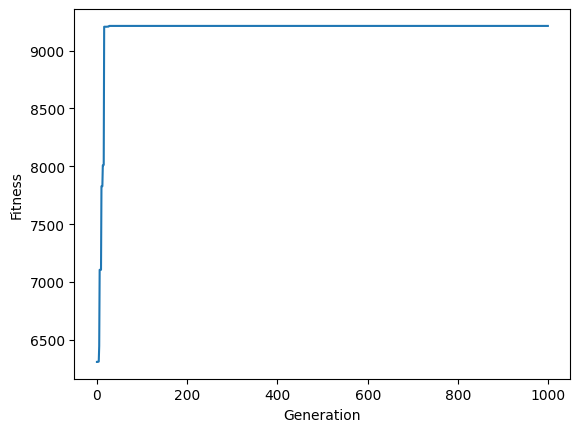

In [ ]:
plt.plot(*stats)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.show()

We now should try to visualize the function and, if it's meaningful, write it to a file.

## Data visualization

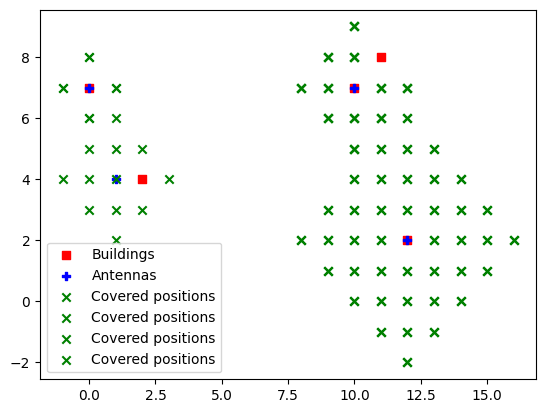

In [ ]:
buildings_positions_x = [building_position[0] for building_position in buildings_positions]
buildings_positions_y = [building_position[1] for building_position in buildings_positions]
plt.scatter(buildings_positions_x, buildings_positions_y, color="red", label="Buildings", marker="s")

antennas_positions_x = [antenna_position[0] for antenna_position in solution]
antennas_positions_y = [antenna_position[1] for antenna_position in solution]
plt.scatter(antennas_positions_x, antennas_positions_y, color="blue", label="Antennas", marker="P")

covered_positions_x: list = []
covered_positions_y: list = []
for antenna_index, antenna_position in enumerate(solution):
    for x in range(antenna_position[0] - antennas_range[antenna_index], antenna_position[0] + antennas_range[
        antenna_index] + 1):
        max_y: int = antennas_range[antenna_index] - abs(x - antenna_position[0])

        for y in range(antenna_position[1] - max_y, antenna_position[1] + max_y + 1):

            if (x, y) not in buildings_positions and (x, y) not in antennas_positions:
                covered_positions_x.append(x)
                covered_positions_y.append(y)

    plt.scatter(covered_positions_x, covered_positions_y, color="green", label="Covered positions", marker="x")

plt.legend()
plt.show()

It's not very meaningful, but we can see that the algorithm has found a good solution. We can now write the solution to a file.

## Writing the solution to a file

We open a file and write the solution in the correct format.

In [ ]:
with open(input_file.replace(".in", ".out"), "w") as f:
    f.write(str(len(antennas_ids)) + "\n")
    for antenna_id, antenna_position in zip(antennas_ids, solution):
        f.write(str(antenna_id) + " " + str(antenna_position[0]) + " " + str(antenna_position[1]) + "\n")

## Conclusion

We have seen how to solve the problem using a genetic algorithm. We have seen how to define the fitness function and how to evolve the population. We have also seen how to visualize the solution and write it to a file.

We can see that the algorithm converges to a good solution, but it's not very fast. We can try to improve the algorithm by using a better fitness function, by using a better crossover function or by using a better mutation function.